In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.utils as utils
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import Dataset, DataLoader
from tensorboardX import SummaryWriter
import glob
import imageio
import random
import numpy as np
import matplotlib.pyplot as plt
# from PIL import Image
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4, 5"


In [2]:
# Create custom dataset
class TrainDatasetP2(Dataset):
    def __init__(self, inputPath):
        self.inputPath = inputPath
        self.inputName = sorted(os.listdir(inputPath))
        # self.transform = transforms.Compose([
        #     transforms.RandomHorizontalFlip(p=1),
        #     # transforms.RandomVerticalFlip(p=0.5),
        #     # transforms.RandomRotation(degrees=15),
        #     transforms.ToTensor()
        # ])
        self.dict = {(0,255,255):0, (255,255,0):1, (255,0,255):2, (0,255,0):3, (0,0,255):4, (255,255,255):5, (0,0,0):6}
        
    def __getitem__(self, index):
        inputImage = Image.open(os.path.join(self.inputPath, self.inputName[2*index+1]))
        label = Image.open(os.path.join(self.inputPath, self.inputName[2*index]))
        # Resize
        resize = transforms.Resize(size=(520,520))
        inputImage = resize(inputImage)
        label = resize(label)
        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            inputImage, output_size=(512,512)
        )
        inputImage = TF.crop(inputImage, i, j, h, w)
        label = TF.crop(label, i, j, h, w)
        
        # Random horizontal flipping
        if random.random() > 0.5:
            inputImage = TF.hflip(inputImage)
            label = TF.hflip(label)
        # Random vertical flipping
        if random.random() > 0.5:
            inputImage = TF.vflip(inputImage)
            label = TF.vflip(label)
        
        # transforms.Compose([
        #     transforms.RandomHorizontalFlip(p=1),
        #     transforms.RandomVerticalFlip(p=0.5),
        #     transforms.RandomRotation(degrees=15),
        #     transforms.ToTensor()
        # ])
        inputImage = TF.to_tensor(inputImage)
        labelVisual = TF.to_tensor(label)
            
        label = np.array(label)
        label_ = np.zeros((label.shape[0], label.shape[1]))
        label_.fill(6)
                
        for rgb, idx in self.dict.items():
            label_[(label.astype(np.uint8)==rgb).all(2)] = idx

        return inputImage, torch.from_numpy(label_).type(torch.LongTensor), labelVisual

    def __len__(self):
        return len(self.inputName)//2


In [3]:
trainsetP2 = TrainDatasetP2(inputPath='/data/dlcv/hw1/hw1_data/p2_data/train')
# valsetP2 = TrainDatasetP2(inputPath='/data/dlcv/hw1/hw1_data/p2_data/validation')
print('# images in trainset:', len(trainsetP2))
# print('# images in valisset:', len(valsetP2))
print('Loading dataset ...')

loaderTrainsetP2 = DataLoader(dataset=trainsetP2, batch_size=24, shuffle=True, num_workers=8)
# loaderValidsetP2 = DataLoader(dataset=valsetP2, batch_size=1, shuffle=False, num_workers=0)

dataiter = iter(loaderTrainsetP2)
images, labels, labelVisual = dataiter.next()
print('Image tensor in each batch:', images.shape, images.dtype)
print('Label tensor in each batch:', labels.shape, labels.dtype)
print('labelVisual tensor in each batch:', labelVisual.shape, labelVisual.dtype)

# images in trainset: 2000
Loading dataset ...


NameError: Caught NameError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/jhccc/anaconda3/envs/dlcv/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/jhccc/anaconda3/envs/dlcv/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/jhccc/anaconda3/envs/dlcv/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_1504991/3386614704.py", line 15, in __getitem__
    inputImage = Image.open(os.path.join(self.inputPath, self.inputName[2*index+1]))
NameError: name 'Image' is not defined


Device used: cuda


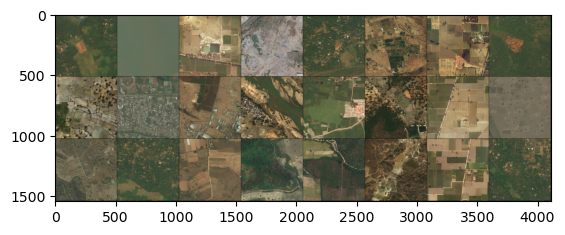

In [ ]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
# print('Labels:')
# print(' '.join('%5s' % labels[j] for j in range(16)))

# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.cuda.manual_seed(42)
device = torch.device("cuda" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

print('Device used:', device)


In [4]:
imshow(torchvision.utils.make_grid(labelVisual))

NameError: name 'imshow' is not defined

In [6]:
class decodeBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(decodeBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 3, 1, 1),
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        x = self.conv(x)
        return x
class vgg(nn.Module):
    def __init__(self, class_num, pretrained=False):
        super(vgg, self).__init__()
        self.vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT, progress=True)
        self.vgg16.classifier = nn.Sequential(
            decodeBlock(512, 4096),
            decodeBlock(4096, 7),
            nn.ConvTranspose2d(7, 7, 64, stride=32),
            nn.BatchNorm2d(7)
        )
    def forward(self, x):
        x = self.vgg16.features(x)
        x = self.vgg16.classifier(x)
        x = x[:,:,16:-16, 16:-16]
        return x

class deeplabv3(nn.Module):
    def __init__(self, in_ch, class_num, pretrained=False):
        super(deeplabv3, self).__init__()
        self.features = models.segmentation.deeplabv3_resnet101(weights=models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT, progress=True)
        self.conv_out = nn.Sequential(
            nn.BatchNorm2d(21),
            nn.ReLU(inplace=True),
            nn.Conv2d(21,32,3,1,1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, class_num, 3, 1, 1),
        )
    def forward(self, x):
        x = self.features(x)['out']
        x = self.conv_out(x)
        return x

def GetVGG(classNum=7, pretrained=False):
    model = vgg(classNum, pretrained)
    return model

def GetDeepLab(classNum = 7, pretrained=False):
    model = deeplabv3(3, classNum, pretrained)
    return model

modelVGG = GetVGG(7, True)
modelDeepLab = GetDeepLab(7, True)
modelDeepLab = torch.nn.DataParallel(module=modelDeepLab, device_ids=[0,1])
# print(modelDeepLab)

vgg(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxP

In [34]:
def visualize(result):
    result_class = np.array(torch.argmax(result.cpu(), dim=1)).astype(np.int16)
    visual = np.zeros((result_class.shape[0], 3, result.shape[2], result.shape[3]))
    dic = {0:(0,255,255), 1:(255,255,0), 2:(255,0,255), 3:(0,255,0), 4:(0,0,255), 5:(255,255,255), 6:(0,0,0)}
    for imgs in range(result_class.shape[0]):
        for idx, rgb in dic.items():
            index = (result_class[imgs]==idx)
            visual[imgs, :, index] = rgb
    return torch.from_numpy(visual/255)

def visualize_label(label):
    label = label.cpu().numpy()
    visual = np.zeros((label.shape[0], 3, label.shape[1], label.shape[2]))
    dic = {0:(0,255,255), 1:(255,255,0), 2:(255,0,255), 3:(0,255,0), 4:(0,0,255), 5:(255,255,255), 6:(0,0,0)}
    for imgs in range(label.shape[0]):
        for idx, rgb in dic.items():
            index = (label[imgs]==idx)
            visual[imgs, :, index] = rgb
    return torch.from_numpy(visual/255)

def train(model, epochs, log_interval = 100):
    model = model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = MultiStepLR(optimizer, milestones=[30,80,130,170], gamma=0.2)
    writer = SummaryWriter("./logs/")
    entropyLoss = nn.CrossEntropyLoss()
    iter = 0
    for epoch in range(epochs):
        for param_group in optimizer.param_groups:
            print('learning rate %f' % param_group["lr"])
        Loss = 0
        for i, (data, target, _) in enumerate(loaderTrainsetP2, 0):
            model.train()
            model.zero_grad()
            optimizer.zero_grad()
            data = Variable(data)
            target = Variable(target)
            data, target = data.to(device), target.to(device)
            
            result, _ = model(data)
            result_class = torch.argmax(result, dim=1)
                        
            loss = entropyLoss(result, target)
            Loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if iter % log_interval == 0:
                print("epoch: {}; loss: {}; TotalLoss: {}".format(epoch+1, loss.item(), Loss))
                # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #     epoch, i * len(data), len(loaderTrainsetP2.dataset),
                #     100. * i / len(loaderTrainsetP2), loss.item()))
            iter += 1
            
        writer.add_scalar('loss', loss.item(), epoch+1)
        writer.add_scalar('OverallLoss', Loss, epoch+1)
        scheduler.step()
        # trainInput = utils.make_grid(data.data, nrow=8, normalize=False, scale_each=True)

        # visual = visualize(result)
        # visual = utils.make_grid(visual, nrow=8, normalize=False, scale_each=True)

        # label = visualize_label(target)
        # label = utils.make_grid(label, nrow=8, normalize=False, scale_each=True)
        
        # writer.add_image('mask', visual, epoch+1)
        # writer.add_image('gt', label, epoch+1)
        # writer.add_image('input', trainInput, epoch+1)
        PATH_report = "./ckpt2/ckptDeepLabReport2_{}_epoch.pkl".format(epoch)
        if epoch==0 or epoch==100 or epoch == 199:
            print('Save checkpointreport......')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, PATH_report
            )

        PATH_P2 = "./ckpt2/ckptDeepLab2_{}_epoch.pkl".format(epoch)
        mIOU = eval(model)
        writer.add_scalar('mIoU', mIOU, epoch+1)
        if mIOU >= 0.73:
            print('Save checkpoint......\n')
            # print('mIOU =', mIOU)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, PATH_P2
            )

def read_masks(filepath):
    '''
    Read masks from directory and tranform to categorical
    '''
    file_list = [file for file in os.listdir(filepath) if file.endswith('mask.png')]
    file_list.sort()
    n_masks = len(file_list)
    masks = np.empty((n_masks, 512, 512))

    for i, file in enumerate(file_list):
        mask = imageio.imread(os.path.join(filepath, file))
        mask = (mask >= 128).astype(int)
        mask = 4 * mask[:, :, 0] + 2 * mask[:, :, 1] + mask[:, :, 2]
        masks[i, mask == 3] = 0  # (Cyan: 011) Urban land 
        masks[i, mask == 6] = 1  # (Yellow: 110) Agriculture land 
        masks[i, mask == 5] = 2  # (Purple: 101) Rangeland 
        masks[i, mask == 2] = 3  # (Green: 010) Forest land 
        masks[i, mask == 1] = 4  # (Blue: 001) Water 
        masks[i, mask == 7] = 5  # (White: 111) Barren land 
        masks[i, mask == 0] = 6  # (Black: 000) Unknown 

    return masks

def mean_iou_score(pred, labels):
    '''
    Compute mean IoU score over 6 classes
    '''
    mean_iou = 0
    for i in range(6):
        tp_fp = np.sum(pred == i)
        tp_fn = np.sum(labels == i)
        tp = np.sum((pred == i) * (labels == i))
        iou = tp / (tp_fp + tp_fn - tp)
        mean_iou += iou / 6
        # print('class #%d : %1.5f'%(i, iou))
    print('mean_iou: %f' % mean_iou)

    return mean_iou
    
def eval(model):
    print('Start eval....')
    transform = transforms.Compose([transforms.ToTensor()])
    model = model.cuda()
    model.eval()
    inputName = sorted(os.listdir("/data/dlcv/hw1/hw1_data/p2_data/validation"))
    for fileName in inputName:
        if "sat" not in fileName:
            continue
        else:
            model.eval()
            image = transform(Image.open(os.path.join("/data/dlcv/hw1/hw1_data/p2_data/validation", fileName))).unsqueeze(0)
            image = image.cuda()
            
            result = model(image)
            result = visualize(result)
            utils.save_image(result, os.path.join("./pred", fileName.split("_")[0]+"_mask.png"))
    return mean_iou_score(read_masks("./pred/"), read_masks("/data/dlcv/hw1/hw1_data/p2_data/validation/"))
    

In [47]:
train(modelVGG, 200)

learning rate 0.001000
epoch: 1; loss: 2.3279190063476562; TotalLoss: 2.3279190063476562


KeyboardInterrupt: 

In [10]:
train(modelDeepLab, 200)

learning rate 0.001000
epoch: 1; loss: 1.8741645812988281; TotalLoss: 1.8741645812988281
Save checkpointreport......
Start eval....


/tmp/ipykernel_1502039/870438921.py:104: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(os.path.join(filepath, file))


mean_iou: 0.304239
learning rate 0.001000
epoch: 2; loss: 0.7086427211761475; TotalLoss: 15.52221930027008
Start eval....
mean_iou: 0.262947
learning rate 0.001000
epoch: 3; loss: 0.8670699596405029; TotalLoss: 25.442811012268066
Start eval....
mean_iou: 0.459321
learning rate 0.001000
epoch: 4; loss: 0.5453671813011169; TotalLoss: 36.006125658750534
Start eval....
mean_iou: 0.532705
learning rate 0.001000
epoch: 5; loss: 0.9060018658638; TotalLoss: 44.05109637975693
Start eval....
mean_iou: 0.428595
learning rate 0.001000
epoch: 6; loss: 0.5543493628501892; TotalLoss: 55.21315613389015
Start eval....
mean_iou: 0.565052
learning rate 0.001000
Start eval....
mean_iou: 0.572047
learning rate 0.001000
epoch: 8; loss: 0.6105217337608337; TotalLoss: 8.8746178150177
Start eval....
mean_iou: 0.416207
learning rate 0.001000
epoch: 9; loss: 0.7461076378822327; TotalLoss: 19.096889853477478
Start eval....
mean_iou: 0.593565
learning rate 0.001000
epoch: 10; loss: 0.536845326423645; TotalLoss: 26

In [14]:
loadModel = GetVGG(7, False)
# loadModel = torch.nn.DataParallel(module=loadModel, device_ids=[0,1])
loadOptimizer = optim.Adam(loadModel.parameters(), lr=0.001)
PATH = "./ckpt2/checkpoint_185_epoch.pkl"
checkpoint = torch.load(PATH)
loadModel.load_state_dict(checkpoint['model_state_dict'])
loadOptimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
loadModel.eval()
_ = eval(loadModel)

Start eval....


/tmp/ipykernel_131874/870438921.py:104: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(os.path.join(filepath, file))


mean_iou: 0.603236


In [13]:
loadModel = GetDeepLab(7, False)
loadModel = torch.nn.DataParallel(module=loadModel, device_ids=[0,1])
loadOptimizer = optim.Adam(loadModel.parameters(), lr=0.001)
PATH = "./ckpt2/ckptDeepLab2_81_epoch.pkl"
PATH0 = "./ckpt2/ckptDeepLabReport2_0_epoch.pkl"
PATH100 = "./ckpt2/ckptDeepLabReport2_100_epoch.pkl"
PATH199 = "./ckpt2/ckptDeepLabReport2_199_epoch.pkl"
checkpoint = torch.load(PATH)
loadModel.load_state_dict(checkpoint['model_state_dict'])
loadOptimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
loadModel.eval()
_ = eval(loadModel)

Start eval....


/tmp/ipykernel_131874/870438921.py:104: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(os.path.join(filepath, file))


mean_iou: 0.735421


In [77]:
mean_iou_score(read_masks("./pred/"), read_masks("/data/dlcv/hw1/hw1_data/p2_data/validation/"))

/tmp/ipykernel_775511/1812290381.py:104: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(os.path.join(filepath, file))


mean_iou: 0.026097


0.026097100200879575

In [48]:
def validation(model) :
    model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    transform = transforms.Compose([transforms.ToTensor()])
    print('Start eval....')
    inputName = sorted(os.listdir("/data/dlcv/hw1/hw1_data/p2_data/validation"))
    for fileName in inputName:
        if "sat" not in fileName:
            continue
        else:
            model.eval()
            image = transform(Image.open(os.path.join("/data/dlcv/hw1/hw1_data/p2_data/validation", fileName))).unsqueeze(0)
            image = image.cuda()
            
            result = model(image)
            result = visualize(result)
            utils.save_image(result, os.path.join("./pred", fileName.split("_")[0]+"_mask.png"))
        # return print(mean_iou_score(read_masks("./pred/"), read_masks("/data/dlcv/hw1/hw1_data/p2_data/validation/")))
validation(loadModel)

Start eval....
